# Set up a regional MOM6 run within CESM framework

There are three main sections: 
1. First we create the MOM6 experiment using the [regional-mom6](https://github.com/COSIMA/regional-mom6/) package. This puts everything we need into two repositories, referred to as the `mom_run_dir` and `mom_input_dir`. These contain all of the configuration files (`MOM_input` etc.) and netcdf input files (`hgrid.nc`, OBC segments etc.) respectively. An `experiment` object is also created within the notebook, containing all the information we need about the regional mom6 setup to pass onto CESM.

2. A new MOM6 CESM case is created in the usual way by cloning the CESM repo and running the `create_case` command. 

3. We modify the new CESM case to work with the regional mom6 configuration we prepared earlier. We pass the path to this CESM run and the experiment object to the `setup_cesm` function, which carries out all the required modifications 

This is very much a work in progress! The goal in the short term was to get something working and make it nice later

# SECTION 1: Setup up you MOM6 regional experiment

This follows the normal workflow, copied from the `reanalysis_forced.ipynb` demo of [regional-mom6](https://github.com/COSIMA/regional-mom6/) but modified for a domain around Hawaii. See the documentation of the package for details and documentation

In [1]:
import regional_mom6 as rmom6

import os
from pathlib import Path
from dask.distributed import Client
client = Client()
client

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

You can log in and use [this GUI](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) to find the lat/lon of your domain and copy paste below.

In [8]:
expt_name = "hawaii-test"

latitude_extent = [16., 27]
longitude_extent = [192, 209]

date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"]

## Place where all your input files go 
input_dir = Path(f"/glade/work/abarnes/inputdirs/{expt_name}/")

## Directory where you'll run the experiment from
run_dir = Path(f"/glade/u/home/abarnes/mom6_rundirs/{expt_name}/")

## Directory where compiled FRE tools are located (needed for construction of mask tables)
toolpath_dir = Path("/glade/u/home/manishrv/documents/regional-mom6-dev/FRE-NCtools")

## Path to where your raw ocean forcing files are stored
glorys_path = Path(f"/glade/work/abarnes/downloads/{expt_name}" )

## if directories don't exist, create them
for path in (run_dir, glorys_path, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Step 2: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [9]:
expt = rmom6.experiment(
    longitude_extent = longitude_extent,
    latitude_extent = latitude_extent,
    date_range = date_range,
    resolution = 0.05,
    number_vertical_layers = 75,
    layer_thickness_ratio = 10,
    depth = 4500,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    toolpath_dir = toolpath_dir
)

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and you'll be prompted for your username and password when you try to run the bash script.

The function is called `get_glorys_rectangular` because the fully automated setup is only supported for domains with boundaries parallel to lines of longitude and latitude. To download more complex domain shapes you can call `rmom6.get_glorys_data` directly.

In [24]:
expt.get_glorys_rectangular(
    raw_boundaries_path=glorys_path,
    boundaries=["north", "south", "east", "west"],
)

script `get_glorys_data.sh` has been greated at /glade/work/abarnes/downloads/hawaii-test.
 Run this script via bash to download the data from a terminal with internet access. 
You will need to enter your Copernicus Marine username and password.
If you don't have an account, make one here:
https://data.marine.copernicus.eu/register


## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [13]:
expt.setup_bathymetry(
    bathymetry_path='/glade/derecho/scratch/manishrv/regional-mom6-data/gebco/GEBCO_2024.nc', 
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation',
    minimum_layers=1
    )

Begin regridding bathymetry...

If this process hangs it means that the chosen domain might be too big to handle this way. After ensuring access to appropriate computational resources, try calling ESMF directly from a terminal in the input directory via

mpirun ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run 'tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.
Regridding in parallel: True


[WARNING] yaksa: 10 leaked handle pool objects


Regridding finished. Now calling `tidy_bathymetry` method for some finishing touches...
Reading in regridded bathymetry to fix up metadata...done.


### Check out your domain:

In [25]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


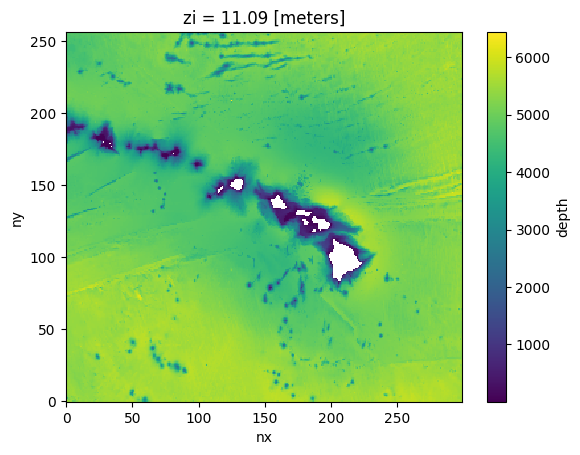

In [26]:
expt.bathymetry.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [ ]:
# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
expt.initial_condition(
    glorys_path / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
expt.rectangular_boundaries(
        glorys_path,
        ocean_varnames,
        boundaries = ["south", "north", "west", "east"],
        arakawa_grid = "A"
        )

## Step 6: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [ ]:
expt.FRE_tools(layout=(10, 10)) ## Here the tuple defines the processor layout

## Step 7: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method and an example `config.yaml` file will be appear in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [ ]:
expt.setup_run_directory(surface_forcing = "jra")

# SECTION 2: Create a blank CESM run

So far I've used Alper's [GUI](https://github.com/ESMCI/visualCaseGen?tab=readme-ov-file) branch of CESM. Clone respective branch of CESM and then run the generate case command. Below is the command I used to generate a global, MOM6 only run forced with JRA data atmosphere

`/glade/u/home/abarnes/cesm-runs/visualCaseGen/cesm2_3_beta17_gui/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res TL319_t232 --case /glade/u/home/abarnes/cesm-runs/cases/hawaii --machine derecho --run-unsupported --project p93300012 --non-local`

In [ ]:
# Save the path where the new CESM config lives
CESM_path = Path(f"/glade/u/home/abarnes/cesm-runs/cases/{expt_name}")

# SECTION 3: Modify the CESM run to make it regional

In [ ]:
from cesm_tools import setup_cesm

setup_cesm(expt, CESM_path)

Now hopefully doing the usual 

`./case.setup && ./case.build && ./case.submit` 

should at least run. Of course from here you'll have a lot of other things to fiddle around with to make it run *well!* 